In [1]:
# read file and create graph

import networkx as nx
import matplotlib.pyplot as plt

# graph representing the bgp network based
bgpNetwork = nx.DiGraph()

with open("bview.20250301.1600.txt", 'r') as file:
    lines = file.readlines()

for line in lines:
    # get the AS path out of the line
    splitLine = line.split("|")
    asPath = splitLine[6]
    pathNodes = asPath.split(" ")

    # need reversed path since path structure is [currentNode, heardFrom, heardFrom... , origin]
    reversedPath = pathNodes[::-1]

    # if this is the origin of the announcement
    if len(reversedPath) == 1:
        bgpNetwork.add_node(reversedPath[0])
        print(reversedPath)
        break

    # otherwise we have multiple ASNs we add an edge from i to i + 1 to capture the full route
    else:
        for i in range(len(reversedPath) - 1):
            if not reversedPath[i] == reversedPath[i + 1]:
                bgpNetwork.add_edge(reversedPath[i], reversedPath[i + 1])

print("Graph created")
print(bgpNetwork.number_of_nodes())
print(bgpNetwork.number_of_edges())

['714']
Graph created
16
23


In [2]:
# helper function

# subgraph creation, bgpNetwork needs to be established and the provided asn value must be a STRING and present in the graph
def bgpSubgraph(asn):
    subgraphNodes = [asn] + list(bgpNetwork.neighbors(asn))
    subgraph = bgpNetwork.subgraph(subgraphNodes)
    return subgraph
    

51
310


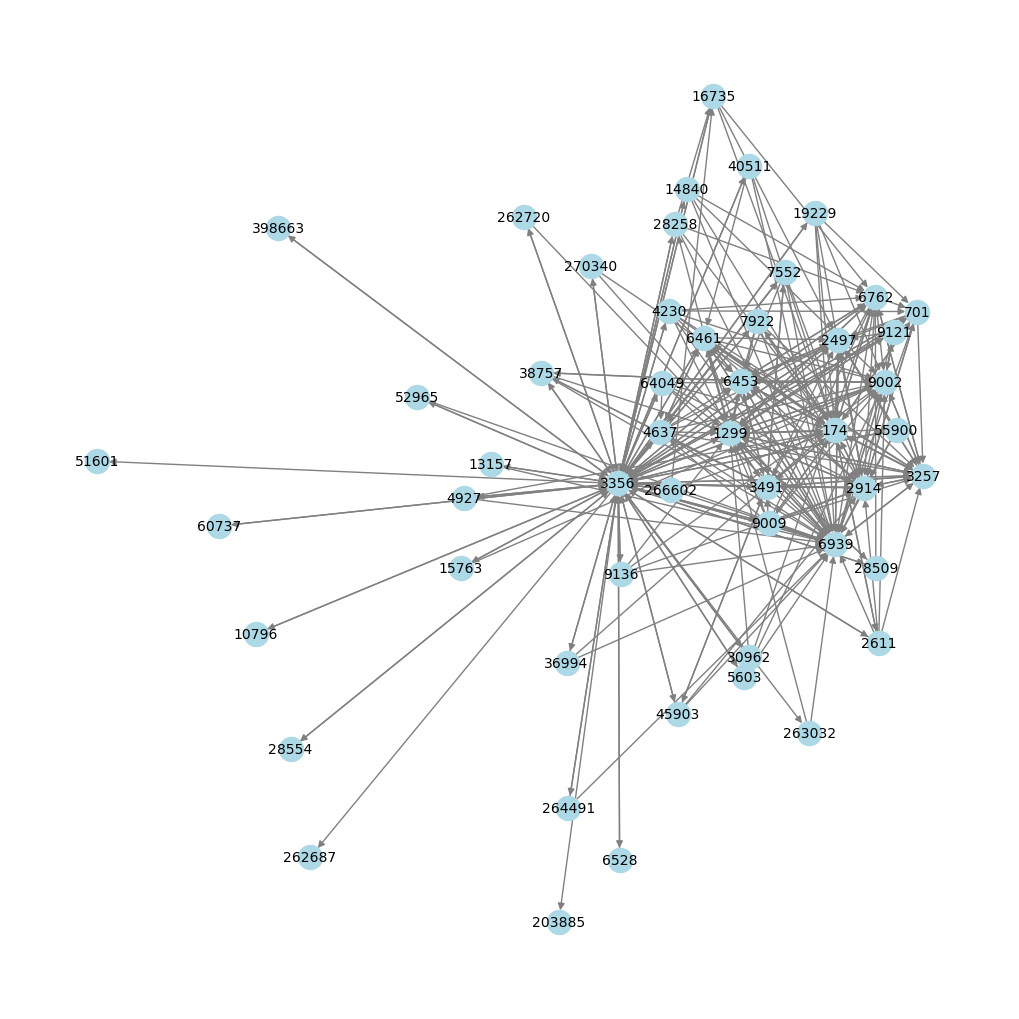

In [6]:
# test use of bgpSubgraph

test = bgpSubgraph("3356")
print(test.number_of_nodes())
print(test.number_of_edges())


pos = nx.spring_layout(test, k=0.8)
plt.figure(figsize=(10, 10))
nx.draw(test, pos, with_labels=True, node_color="lightblue", edge_color="gray", font_size=10, arrows=True)
plt.show()

In [5]:
import pandas as pd
# Node features to input into Machine Learning Algo 

# out-degrees dictionary 
out_degree_dict = dict(bgpNetwork.out_degree())

# in-degrees dictionary
in_degree_dict = dict(bgpNetwork.in_degree())

# degree centrality 
degree_centrality = nx.degree_centrality(bgpNetwork)

# closeness centrality, takes a while but seems resonable time
closeness_centrality = nx.closeness_centrality(bgpNetwork)



# convert to DataFrame for ML
df = pd.DataFrame.from_dict(out_degree_dict, orient='index', columns=['out_degree'])

# to add more columns (features) to the table 
#df['column name'] = values 

df['in_degree'] = in_degree_dict
df['degree_centrality'] = degree_centrality
df['closeness_centrality'] = closeness_centrality

print("Data Frame:")
print(df.head())


Data Frame:
       out_degree  in_degree  degree_centrality  closeness_centrality
749             1          0           0.000012              0.000000
3356           50       6352           0.076207              0.403578
1299           51       2450           0.029771              0.400301
13030           7        801           0.009618              0.353370
2914           36       1482           0.018070              0.367812
